### This notebook consists of the EDA and the training of A CNN-LSTM model after the most optimal hyperparameters were found.


In [ ]:
!pip install Tiingo

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tiingo import TiingoClient
import matplotlib.pyplot as plt



In [ ]:
TIINGO_API_KEY = 'eb8c1356691d12308c89ebf118ec0b2c34a50d4f'
config = {'api_key': TIINGO_API_KEY, 'session': True}
client = TiingoClient(config)


In [ ]:
# Retrieve Data
def fetch_data(ticker, start_date, end_date):
    historical_prices = client.get_ticker_price(ticker,
                                                fmt='json',
                                                startDate=start_date,
                                                endDate=end_date,
                                                frequency='daily')
    df = pd.DataFrame(historical_prices)
    display(df)
    return df[['date', 'close']]

In [ ]:
# Data Preprocessing
def preprocess_data(df, sequence_length):
    data = df['close'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_normalized) - sequence_length):
        X.append(data_normalized[i:i + sequence_length])
        y.append(data_normalized[i + sequence_length])
    return np.array(X), np.array(y), scaler


In [ ]:
# Main Execution
ticker = 'AAPL'
start_date = '2021-01-01'
end_date = '2023-12-31'
sequence_length = 10

df = fetch_data(ticker, start_date, end_date)
X, y, scaler = preprocess_data(df, sequence_length)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

for i in range(5):
  print(X[i].flatten(),":",y[i],"\n")

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2021-01-04T00:00:00.000Z,129.41,133.6116,126.760,133.52,143301887,127.006381,131.129942,124.405602,131.040044,143301887,0.0,1.0
1,2021-01-05T00:00:00.000Z,131.01,131.7400,128.430,128.89,97664898,128.576664,129.293105,126.044584,126.496040,97664898,0.0,1.0
2,2021-01-06T00:00:00.000Z,126.60,131.0499,126.382,127.72,155087970,124.248573,128.615822,124.034622,125.347771,155087970,0.0,1.0
3,2021-01-07T00:00:00.000Z,130.92,131.6300,127.860,128.36,109578157,128.488335,129.185148,125.485171,125.975884,109578157,0.0,1.0
4,2021-01-08T00:00:00.000Z,132.05,132.6300,130.230,132.43,105158245,129.597347,130.166574,127.811151,129.970289,105158245,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2023-12-22T00:00:00.000Z,193.60,195.4100,192.970,195.18,37149570,193.354276,195.161978,192.725075,194.932270,37149570,0.0,1.0
749,2023-12-26T00:00:00.000Z,193.05,193.8900,192.830,193.61,28919310,192.804974,193.643908,192.585253,193.364263,28919310,0.0,1.0
750,2023-12-27T00:00:00.000Z,193.15,193.5000,191.090,192.49,47899806,192.904847,193.254403,190.847462,192.245685,47899806,0.0,1.0
751,2023-12-28T00:00:00.000Z,193.58,194.6600,193.170,194.14,34049898,193.334301,194.412930,192.924822,193.893590,34049898,0.0,1.0


[0.15963303 0.17920489 0.12525994 0.17810398 0.19192661 0.15437309
 0.15217125 0.177737   0.15351682 0.13186544] : [0.14030581] 

[0.17920489 0.12525994 0.17810398 0.19192661 0.15437309 0.15217125
 0.177737   0.15351682 0.13186544 0.14030581] : [0.19168196] 

[0.12525994 0.17810398 0.19192661 0.15437309 0.15217125 0.177737
 0.15351682 0.13186544 0.14030581 0.19168196] : [0.25088685] 

[0.17810398 0.19192661 0.15437309 0.15217125 0.177737   0.15351682
 0.13186544 0.14030581 0.19168196 0.25088685] : [0.27779817] 

[0.19192661 0.15437309 0.15217125 0.177737   0.15351682 0.13186544
 0.14030581 0.19168196 0.25088685 0.27779817] : [0.32489297] 



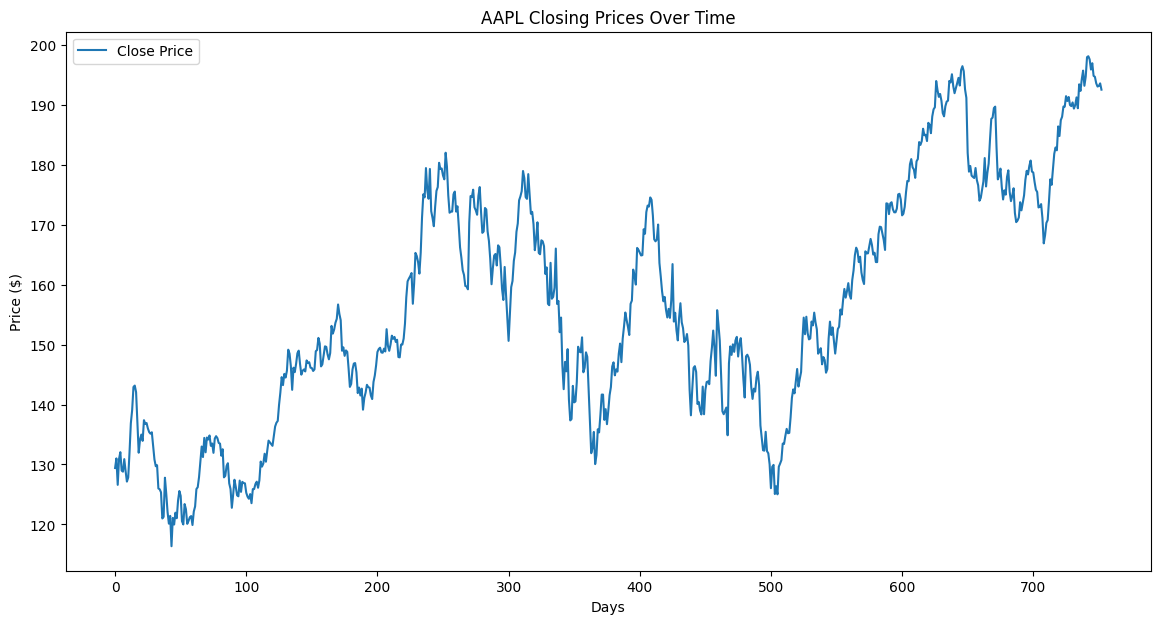

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df.close, label='Close Price')
plt.title('AAPL Closing Prices Over Time')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

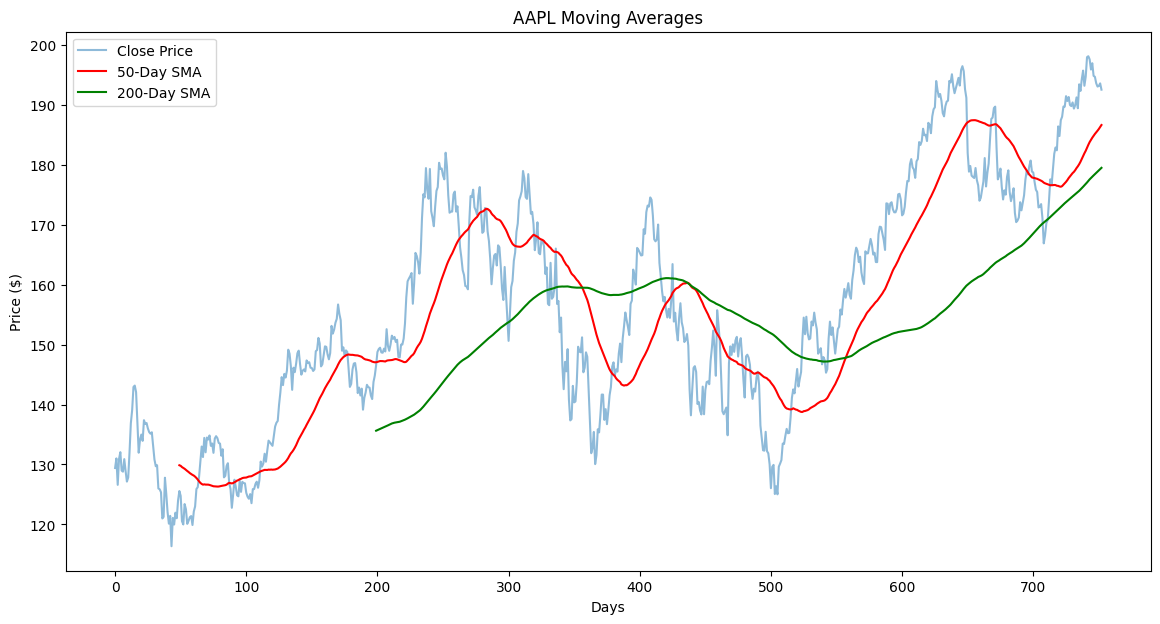

In [ ]:
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.5)
plt.plot(df.index, df['SMA_50'], label='50-Day SMA', color='red')
plt.plot(df.index, df['SMA_200'], label='200-Day SMA', color='green')
plt.title('AAPL Moving Averages')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

#### Historical volatility (HV) is a statistical measure that quantifies the degree of variation in a stock's price over time, expressed as an annualized standard deviation of the logarithmic returns. Essentially, it provides a measure of how much the price of an asset has fluctuated around its mean price over a specified period.

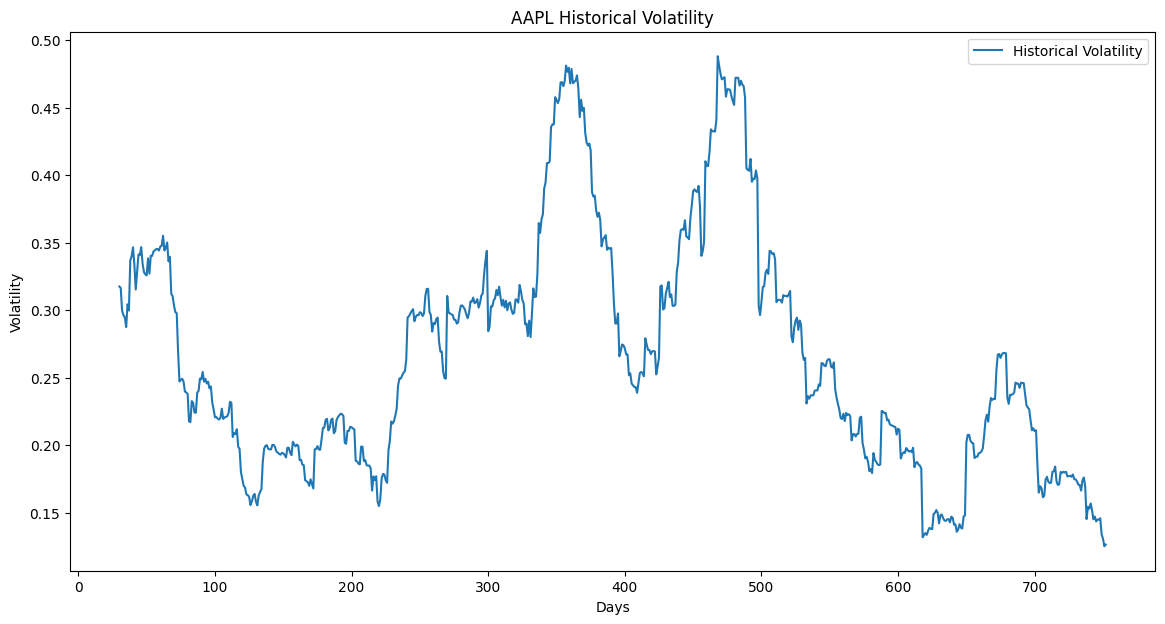

In [ ]:
df['log_return'] = np.log(df['close'] / df['close'].shift())
df['volatility'] = df['log_return'].rolling(window=30).std() * np.sqrt(252)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['volatility'], label='Historical Volatility')
plt.title('AAPL Historical Volatility')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [ ]:
# CNN-LSTM Model
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(CNNLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(64, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
# Model parameters
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1

# Initialize model, define loss function and optimizer
model = CNNLSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 200

# Initialize lists to store loss values for plotting
train_losses = []
test_losses = []

# Training Loop with Test Loss Calculation
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    train_outputs = model(X_train)
    train_loss = criterion(train_outputs, y_train)
    train_loss.backward()
    optimizer.step()

    # Store train loss
    train_losses.append(train_loss.item())

    # Evaluate on test data & store test loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
    if (epoch+1)%10==0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}')


#section for making predictions on training data
model.eval()
with torch.no_grad():
    train_predictions = model(X_train)
    test_predictions = model(X_test)

# Inverse transform the predictions and actual values
train_actual_prices = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
train_predicted_prices = scaler.inverse_transform(train_predictions.numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.numpy().reshape(-1, 1))



Epoch 10/200, Train Loss: 0.07235338538885117, Test Loss: 0.04544827714562416
Epoch 20/200, Train Loss: 0.03151443228125572, Test Loss: 0.029339736327528954
Epoch 30/200, Train Loss: 0.023073067888617516, Test Loss: 0.02026733011007309
Epoch 40/200, Train Loss: 0.010342663154006004, Test Loss: 0.011865093372762203
Epoch 50/200, Train Loss: 0.005278837867081165, Test Loss: 0.005425732582807541
Epoch 60/200, Train Loss: 0.004753878805786371, Test Loss: 0.004848816432058811
Epoch 70/200, Train Loss: 0.004079706035554409, Test Loss: 0.004248145502060652
Epoch 80/200, Train Loss: 0.0038043514359742403, Test Loss: 0.0043145339004695415
Epoch 90/200, Train Loss: 0.00368198798969388, Test Loss: 0.004162736237049103
Epoch 100/200, Train Loss: 0.0035733983386307955, Test Loss: 0.004007514100521803
Epoch 110/200, Train Loss: 0.003499339334666729, Test Loss: 0.0039282734505832195
Epoch 120/200, Train Loss: 0.0034281564876437187, Test Loss: 0.003857335774227977
Epoch 130/200, Train Loss: 0.00336148

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert tensors to numpy arrays for compatibility with sklearn metrics
train_actual_prices_np = train_actual_prices.flatten()
train_predicted_prices_np = train_predicted_prices.flatten()
test_actual_prices_np = test_actual_prices.flatten()
test_predicted_prices_np = test_predicted_prices.flatten()

# RMSE
train_rmse = np.sqrt(mean_squared_error(train_actual_prices_np, train_predicted_prices_np))
test_rmse = np.sqrt(mean_squared_error(test_actual_prices_np, test_predicted_prices_np))

# MAE
train_mae = mean_absolute_error(train_actual_prices_np, train_predicted_prices_np)
test_mae = mean_absolute_error(test_actual_prices_np, test_predicted_prices_np)

# R² Score
train_r2 = r2_score(train_actual_prices_np, train_predicted_prices_np)
test_r2 = r2_score(test_actual_prices_np, test_predicted_prices_np)

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}\n")
print(f"Training MAE: {train_mae}")
print(f"Testing MAE: {test_mae}\n")
print(f"Training R²: {train_r2}")
print(f"Testing R²: {test_r2}\n")

Training RMSE: 4.167980194091797
Testing RMSE: 4.389950275421143

Training MAE: 3.286749839782715
Testing MAE: 3.584942102432251

Training R²: 0.9550962701583943
Testing R²: 0.951669003777518



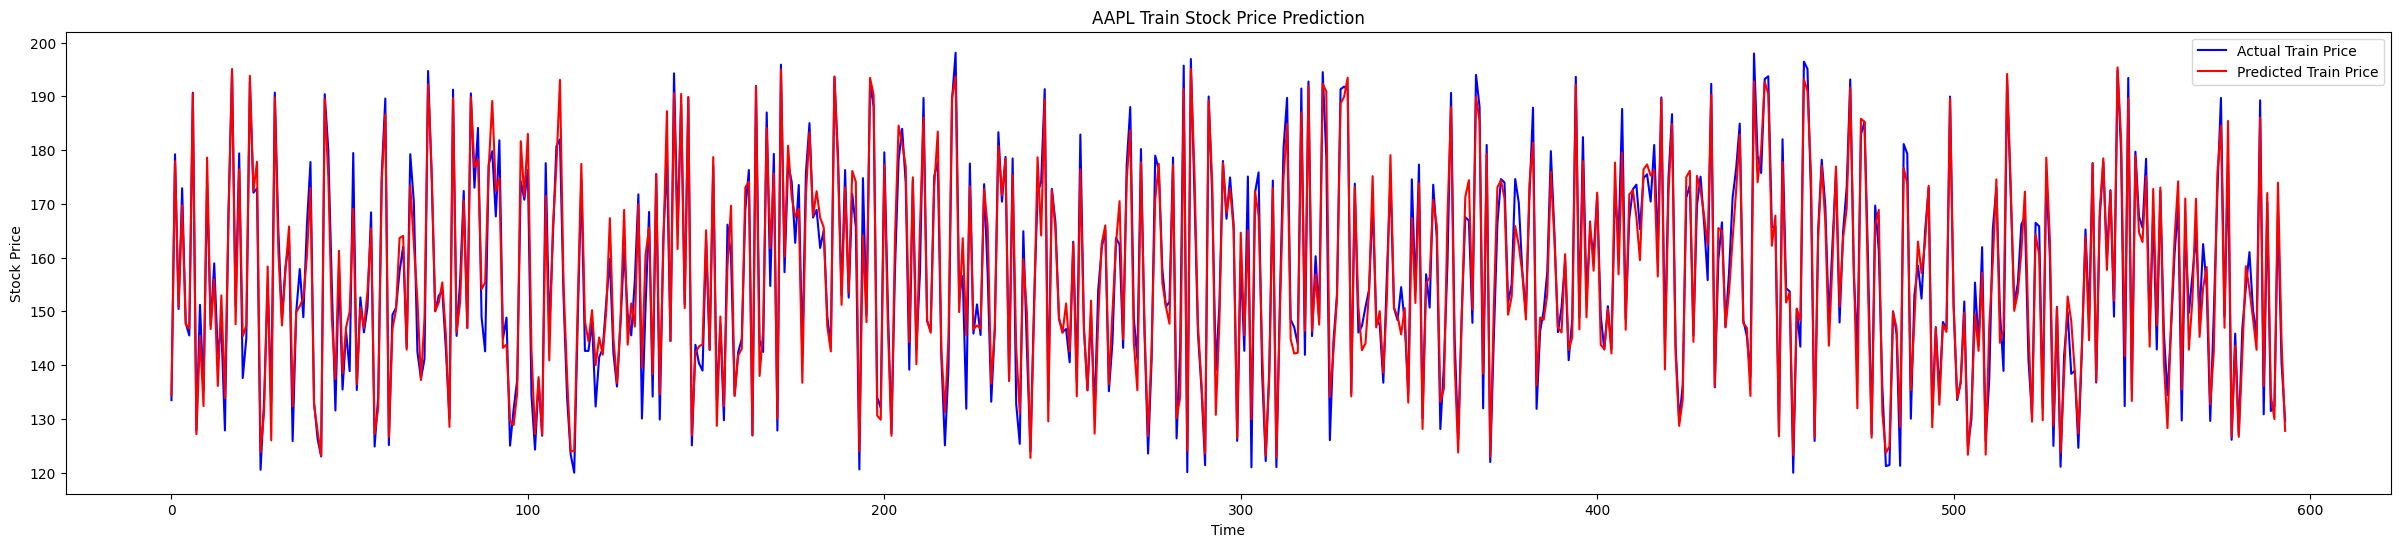

In [ ]:
# A) Train Data vs Predictions
plt.figure(figsize=(30, 6))
plt.plot(train_actual_prices, label='Actual Train Price', color='blue')
plt.plot(train_predicted_prices, label='Predicted Train Price', color='red')
plt.title(f'{ticker} Train Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

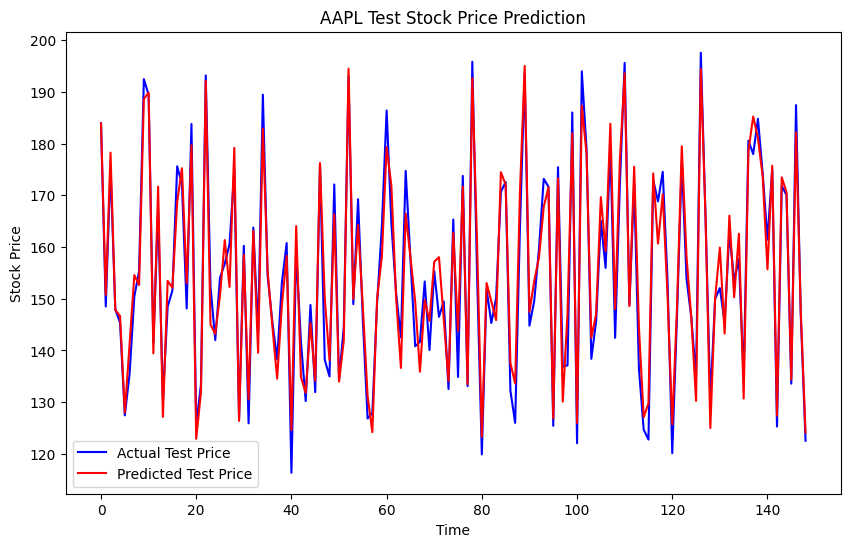

In [ ]:
# B) Test Data vs Predictions
plt.figure(figsize=(10, 6))
plt.plot(test_actual_prices, label='Actual Test Price', color='blue')
plt.plot(test_predicted_prices, label='Predicted Test Price', color='red')
plt.title(f'{ticker} Test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

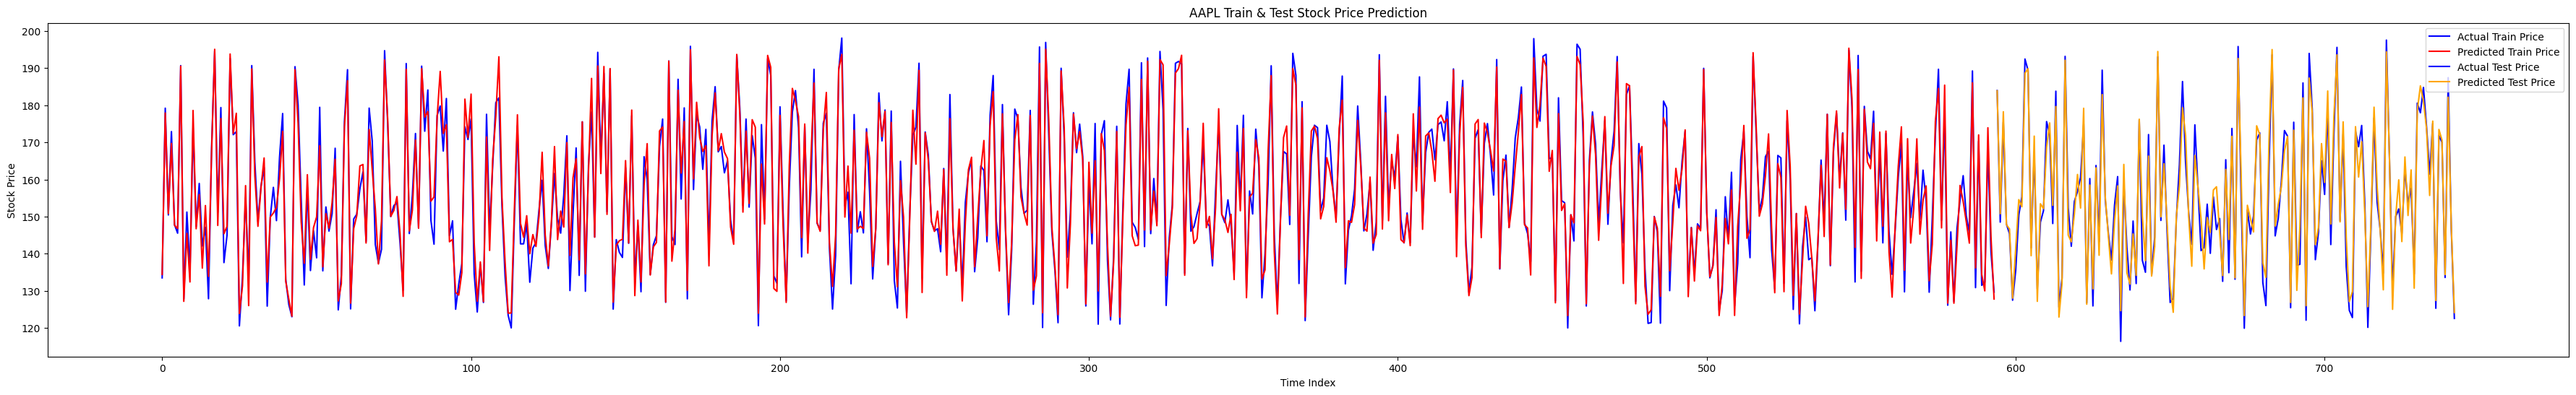

In [ ]:
# C) Train and Test Data vs Predictions
plt.figure(figsize=(45, 6))

# Segment lengths for plotting clarity
train_len = len(train_actual_prices)
test_len = len(test_actual_prices)
total_len = train_len + test_len

# Plot Train Data and Predictions
plt.plot(range(train_len), train_actual_prices, label='Actual Train Price', color='blue')
plt.plot(range(train_len), train_predicted_prices, label='Predicted Train Price', color='red')

# Plot Test Data and Predictions
plt.plot(range(train_len, total_len), test_actual_prices, label='Actual Test Price', color='blue')
plt.plot(range(train_len, total_len), test_predicted_prices, label='Predicted Test Price', color='orange')

plt.title(f'{ticker} Train & Test Stock Price Prediction')
plt.xlabel('Time Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show


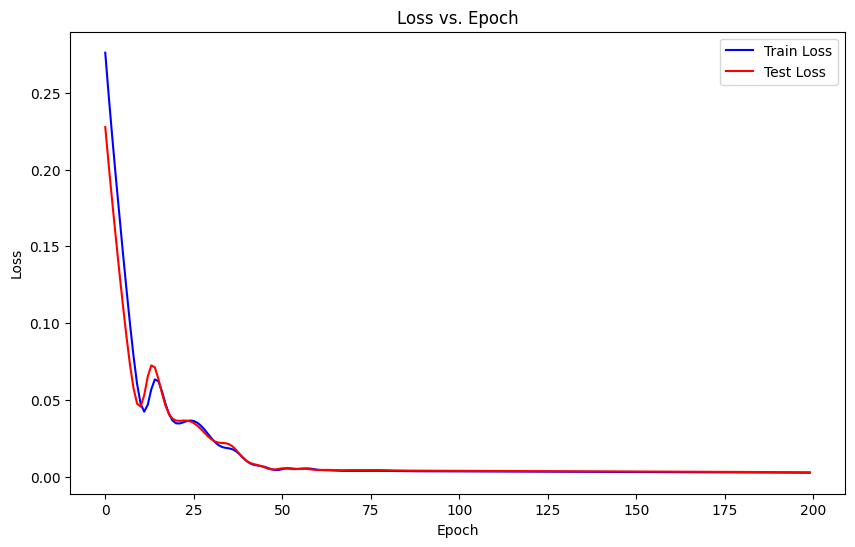

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predicting AAPL stock price for 16th Jan 2024

In [ ]:
end_date = '2024-01-16'  # The date we want to predict for
start_date = '2023-12-30'  # Adjusted for 'sequence_length' of 10 days

new_df = fetch_data(ticker, start_date, end_date)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2024-01-02T00:00:00.000Z,185.64,188.4400,183.885,187.150,82488674,185.404379,188.200825,183.651606,186.912462,82488674,0.0,1.0
1,2024-01-03T00:00:00.000Z,184.25,185.8800,183.430,184.220,58414460,184.016143,185.644074,183.197184,183.986181,58414460,0.0,1.0
2,2024-01-04T00:00:00.000Z,181.91,183.0872,180.880,182.150,71983570,181.679113,182.854819,180.650420,181.918809,71983570,0.0,1.0
3,2024-01-05T00:00:00.000Z,181.18,182.7600,180.170,181.990,62196924,180.950040,182.528034,179.941322,181.759012,62196924,0.0,1.0
4,2024-01-08T00:00:00.000Z,185.56,185.6000,181.500,182.085,59144470,185.324480,185.364430,181.269634,181.853891,59144470,0.0,1.0
5,2024-01-09T00:00:00.000Z,185.14,185.1500,182.730,183.920,42841809,184.905013,184.915001,182.498072,183.686562,42841809,0.0,1.0
6,2024-01-10T00:00:00.000Z,186.19,186.4000,183.920,184.350,46792908,185.953681,186.163414,183.686562,184.116016,46792908,0.0,1.0
7,2024-01-11T00:00:00.000Z,185.59,187.0500,183.620,186.540,49128408,185.354442,186.812589,183.386943,186.303237,49128408,0.0,1.0
8,2024-01-12T00:00:00.000Z,185.92,186.7400,185.190,186.060,40477782,185.684023,186.502983,184.954950,185.823846,40477782,0.0,1.0
9,2024-01-16T00:00:00.000Z,183.63,184.2600,180.934,182.160,65603041,183.396930,184.026130,180.704352,181.928796,65603041,0.0,1.0


In [ ]:
def preprocess_single_day_data(df, scaler, sequence_length):
    data = df['close'].values.reshape(-1, 1)
    data_normalized = scaler.transform(data)
    X = data_normalized[-sequence_length:].reshape(1, sequence_length, 1)  # Reshape for single prediction
    return torch.from_numpy(X).float()  # Convert to PyTorch tensor and ensure type is float

X_new = preprocess_single_day_data(new_df, scaler, sequence_length)

In [ ]:
with torch.no_grad():
    predicted_normalized_price = model(X_new)

In [ ]:
predicted_price = scaler.inverse_transform(predicted_normalized_price.reshape(-1, 1))
print(f"Predicted close price for {ticker} on {end_date} is ${predicted_price[0][0]:.2f}")

Predicted close price for AAPL on 2024-01-16 is $184.72


## Predicting AAPL stock price for 20th March  2024

In [ ]:
end_date = '2024-03-20'  # The date you want to predict for
start_date = '2024-03-07'  # Adjusted for 'sequence_length' of 10 days

new_df = fetch_data(ticker, start_date, end_date)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2024-03-07T00:00:00.000Z,169.00,170.7300,168.490,169.15,71765061,169.00,170.7300,168.490,169.15,71765061,0.0,1.0
1,2024-03-08T00:00:00.000Z,170.73,173.7000,168.940,169.00,76267041,170.73,173.7000,168.940,169.00,76267041,0.0,1.0
2,2024-03-11T00:00:00.000Z,172.75,174.3800,172.050,172.94,58929918,172.75,174.3800,172.050,172.94,58929918,0.0,1.0
3,2024-03-12T00:00:00.000Z,173.23,174.0300,171.010,173.15,59544927,173.23,174.0300,171.010,173.15,59544927,0.0,1.0
4,2024-03-13T00:00:00.000Z,171.13,173.1850,170.760,172.77,51948951,171.13,173.1850,170.760,172.77,51948951,0.0,1.0
5,2024-03-14T00:00:00.000Z,173.00,174.3078,172.050,172.91,72571635,173.00,174.3078,172.050,172.91,72571635,0.0,1.0
6,2024-03-15T00:00:00.000Z,172.62,172.6200,170.285,171.17,121752699,172.62,172.6200,170.285,171.17,121752699,0.0,1.0
7,2024-03-18T00:00:00.000Z,173.72,177.7100,173.520,175.57,75604184,173.72,177.7100,173.520,175.57,75604184,0.0,1.0
8,2024-03-19T00:00:00.000Z,176.08,176.6050,173.030,174.34,55215244,176.08,176.6050,173.030,174.34,55215244,0.0,1.0
9,2024-03-20T00:00:00.000Z,178.67,178.6700,175.090,175.72,53423102,178.67,178.6700,175.090,175.72,53423102,0.0,1.0


In [ ]:
X_new = preprocess_single_day_data(new_df, scaler, sequence_length)
with torch.no_grad():
    predicted_normalized_price = model(X_new)
predicted_price = scaler.inverse_transform(predicted_normalized_price.reshape(-1, 1))
print(f"Predicted close price for {ticker} on {end_date} is ${predicted_price[0][0]:.2f}")

Predicted close price for AAPL on 2024-03-20 is $174.57


## Predicting AAPL stock price for 18th April 2024

In [ ]:
end_date = '2024-04-18'  # The date you want to predict for
start_date = '2024-04-05'  # Adjusted for 'sequence_length' of 10 days

new_df = fetch_data(ticker, start_date, end_date)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2024-04-05T00:00:00.000Z,169.58,170.39,168.95,169.59,41975776,169.58,170.39,168.95,169.59,41975776,0.0,1.0
1,2024-04-08T00:00:00.000Z,168.45,169.20,168.24,169.03,37216858,168.45,169.20,168.24,169.03,37216858,0.0,1.0
2,2024-04-09T00:00:00.000Z,169.67,170.08,168.35,168.70,42231444,169.67,170.08,168.35,168.70,42231444,0.0,1.0
3,2024-04-10T00:00:00.000Z,167.78,169.09,167.11,168.80,49709336,167.78,169.09,167.11,168.80,49709336,0.0,1.0
4,2024-04-11T00:00:00.000Z,175.04,175.46,168.16,168.34,91070275,175.04,175.46,168.16,168.34,91070275,0.0,1.0
5,2024-04-12T00:00:00.000Z,176.55,178.36,174.21,174.26,101670886,176.55,178.36,174.21,174.26,101670886,0.0,1.0
6,2024-04-15T00:00:00.000Z,172.69,176.63,172.50,175.36,73531773,172.69,176.63,172.50,175.36,73531773,0.0,1.0
7,2024-04-16T00:00:00.000Z,169.38,173.76,168.27,171.75,73711235,169.38,173.76,168.27,171.75,73711235,0.0,1.0
8,2024-04-17T00:00:00.000Z,168.00,170.65,168.00,169.61,50901210,168.00,170.65,168.00,169.61,50901210,0.0,1.0
9,2024-04-18T00:00:00.000Z,167.04,168.64,166.55,168.03,43122903,167.04,168.64,166.55,168.03,43122903,0.0,1.0


In [ ]:
X_new = preprocess_single_day_data(new_df, scaler, sequence_length)
with torch.no_grad():
    predicted_normalized_price = model(X_new)
predicted_price = scaler.inverse_transform(predicted_normalized_price.reshape(-1, 1))
print(f"Predicted close price for {ticker} on {end_date} is ${predicted_price[0][0]:.2f}")

Predicted close price for AAPL on 2024-04-18 is $171.18
